## Example: Stochastic modeling of a bioreactor


We will look at alcohol fermentation through the lens of Monte-Carlo simulation.. Our system is a batch reactor


Sugar (mg/L): $\frac{dS}{dt} = -abSX - afSX $

Yeast (cell/L): $\frac{dX}{dt} = acSX - dXA $

Alcohol (mg/L): $\frac{dA}{dt} = abSX $

where:
    a = rate constant for sugar breakdown
    b = fraction of sugar breakdown that yields alcohol
    c = rate of yeast cell formation per unit breakdown of sugar 
    d = death rate of cells per unit alcohol
    f = fraction of sugar breakdown that yields CO2

Yeast grows at a rate given by acSY, and dies due to alcohol toxicity according to dYA,
Alcohol is produced at a rate given by abSY.
Initially, S0=52000 mg/L, Y0=100 cells/L, A0=0.

For parameters, assume the following:
a = 0.00002; 
b = 0.66667; 
c = 0.03; 
d = 0.00000035; 
f=1-b

Run the model for 400 time units.


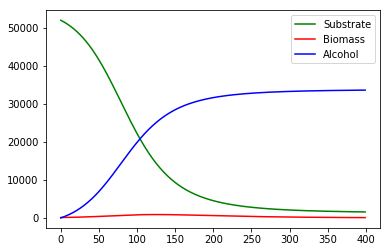

In [8]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


a = 0.00002    # rate constant for sugar breakdown
b = 0.66667    # fraction of sugar breakdown that yields alcoho#  
c = 0.03       # rate of yeast cell formation per unit breakdown of sugar 
d = 0.00000035 # death rate of cells per unit alcohol

f=1-b   #  fraction of sugar breakdown that yields CO2

def BioreactorModel(Y,t):
    # state variables
    S = Y[0]    # sugar content,  mg/L
    X = Y[1]    # yeast, cells/L
    A = Y[2]    # alcohol content, mg/L

    dS_dt = -a*b*S*X - a*f*S*X;
    dX_dt = a*c*S*X - d*X*A;
    dA_dt = a*b*S*X;
    
    return [dS_dt, dX_dt, dA_dt]


times = np.arange( 0, 400, 1)
Y = odeint( BioreactorModel, [52000,100,0], times)

plt.plot(times,Y[:,0], 'g', label="Substrate")
plt.plot(times,Y[:,1], 'r', label="Biomass")
plt.plot(times,Y[:,2], 'b', label="Alcohol")
plt.legend()
plt.show()


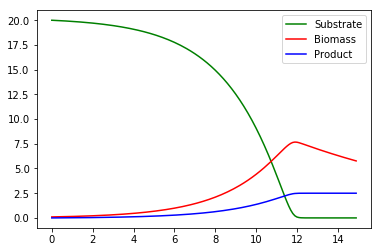

In [57]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


mumax = 0.5
Ks = 0.75
Kd = 0.1
Yxs = 0.5
qp = 0.25

def BioreactorModel(Y,t):
    # state variables
    S = Y[0]    # sugar content,  mg/L
    X = Y[1]    # yeast, cells/L
    P = Y[2]    # alcohol content, mg/L

    mu = mumax*S/(Ks + S)
    
    dX_dt = mu*X - Kd*X;
    dS_dt = -(1/Yxs)*(mu*X)
    dP_dt = qp*mu*X;
    
    return [dS_dt, dX_dt, dP_dt]


times = np.arange( 0, 15, 0.1)
Y = odeint( BioreactorModel, [20,0.1,0], times)

plt.plot(times,Y[:,0], 'g', label="Substrate")
plt.plot(times,Y[:,1], 'r', label="Biomass")
plt.plot(times,Y[:,2], 'b', label="Product")
plt.legend()
plt.show()


Flows: shape=0.35,  loc=0.2,  scale=1.8


/usr/local/lib/python3.5/dist-packages/scipy/stats/_continuous_distns.py:412: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Aerations: mean=0.012,  stddev=0.005


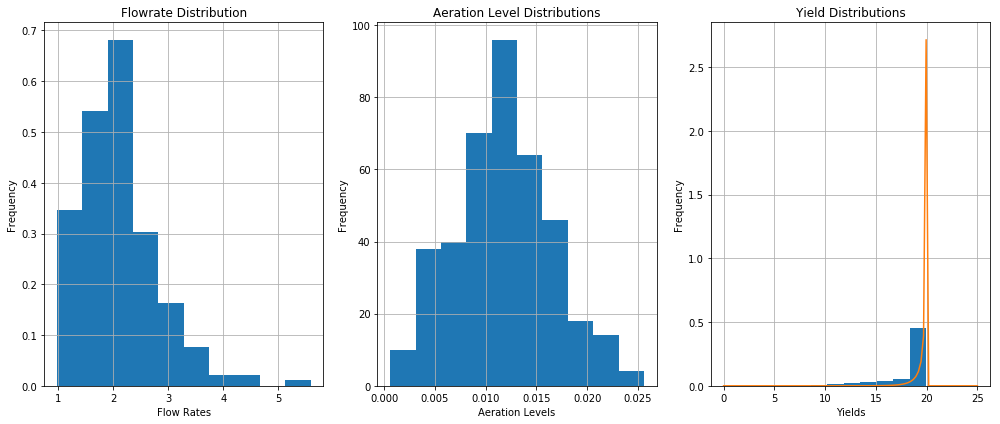

In [74]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import beta
# open the file
df = pd.read_excel( "http://explorer.bee.oregonstate.edu/topic/Modeling/data/MCFishOxygen.xlsx" )

# extract data
flows = df['flowrate']
aerations = df['aeration']

# fit and freeze probability distributions
shape, loc, scale = lognorm.fit(flows, 0, loc=0, scale=0 )
pdFlows = lognorm(shape,loc=loc,scale=scale)
print( "Flows: shape=%.2f,  loc=%.1f,  scale=%.1f" % ( shape,loc,scale ) )

mean, stddev = norm.fit(aerations)
pdAerations = norm(loc=mean,scale=stddev)
print( "Aerations: mean=%.3f,  stddev=%.3f" % ( mean, stddev ) )


# known model parameters.  Note: units are L, g, day
flowrate = 2     # L/L/day
kO2 = 0.0012     # gO2/gFish/ day
kGrowth = 0.05   # g/g/day
O2in = 0.008     # g/L
km = 4700        # 
aeration = 0.0   # g/L/day

FInit = 1
O2Init = 0.008

###### Fish/Oxygen model ######
def theModel(y,t):
    F = y[0]
    O2 = y[1]
    dF_dt  = kGrowth*F - np.exp(-km*O2) * F
    dO2_dt = flowrate*(O2in-O2) - (kO2*F) + aeration
    return [ dF_dt, dO2_dt]


# Monte carlo:
count = 100
rvs_flowrate = pdFlows.rvs(size=count)
rvs_aeration = pdAerations.rvs(size=count)

Yields = np.zeros(count*count)

times = np.arange(0,60,0.1)
i = 0
for _f in rvs_flowrate:
    for _a in rvs_aeration:
        flowrate = _f
        aeration = _a
        
        Y = odeint( theModel, [FInit,O2Init], times)
        Yields[i] = Y[-1,0]
        i += 1

        
        
# fit a beta distribution
a,b,loc,scale = beta.fit(Yields)
pdYields=beta(a,b,loc=loc,scale=scale)
x = np.linspace(0,25,100)

# lower plot - state variables through time
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.hist(flows,normed=True)
plt.grid()
plt.xlabel('Flow Rates')
plt.ylabel( 'Frequency')
plt.title( 'Flowrate Distribution')
            
plt.subplot(1,3,2)            
plt.hist(aerations,normed=True)
plt.grid()
plt.xlabel('Aeration Levels')
plt.ylabel('Frequency')
plt.title('Aeration Level Distributions')

plt.subplot(1,3,3)            
plt.hist(Yields,normed=True)
plt.plot(x,pdYields.pdf(x))
plt.grid()
plt.xlabel('Yields')
plt.ylabel( 'Frequency')
plt.title( 'Yield Distributions')

plt.tight_layout()
plt.show()

fit(): mean=0.00,  std=0.0


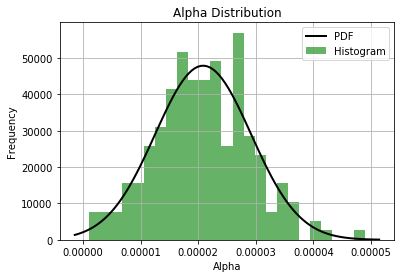

In [22]:
import pandas as pd
from scipy.stats import norm

df = pd.read_excel( 'http://explorer.bee.oregonstate.edu/Topic/Modeling/data/MCBioreactorParamValues.xlsx' )

alphas = df['Alpha']

mean, std = norm.fit(alphas)
print( "fit(): mean=%.2f,  std=%.1f" % ( mean,std ) )
pdAlphas = norm(loc=mean,scale=std)   # freeze the distribution

# Plot the histogram.
#plt.figure(figsize=(8,6))
plt.hist(alphas, bins=25, normed=True, alpha=0.6, color='g', label='Histogram')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = pdAlphas.pdf(x)
plt.plot(x, p, 'k', linewidth=2, label='PDF')

plt.xlabel('Alpha')
plt.ylabel('Frequency')
plt.title('Alpha Distribution')
plt.legend()
plt.grid()
plt.show()


## Perform Monte Carlo Simulation

/usr/local/lib/python3.5/dist-packages/scipy/stats/_continuous_distns.py:412: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


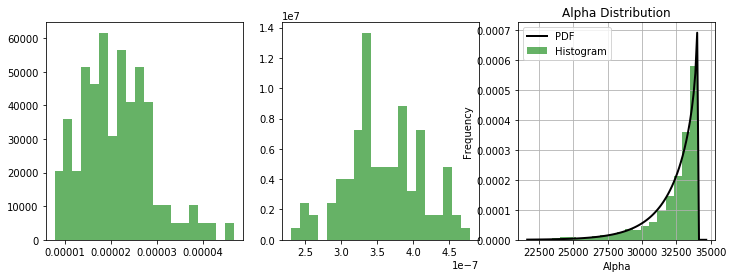

In [36]:
from scipy.stats import beta

count = 100
rvs_d = norm.rvs(loc=0.00000035,scale=0.00000006,size=count)
rvs_a = pdAlphas.rvs(size=count)

Yields = np.zeros(len(rvs_d)*len(rvs_a))

i = 0
for _d in rvs_d:
    for _a in rvs_a:
        d = _d
        a = _a
        
        if ( d < 0 ):
            d = 0
        if (a < 0 ):
            a=0
        Y = odeint( BioreactorModel, [52000,100,0], times)
        Yields[i] = Y[-1,2]
        i += 1
        
# Plot the histogram.
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist(rvs_a, bins=20, normed=True, alpha=0.6, color='g', label='Histogram')

plt.subplot(132)
plt.hist(rvs_d, bins=20, normed=True, alpha=0.6, color='g', label='Histogram')

plt.subplot(133)
plt.hist(Yields, bins=20, normed=True, alpha=0.6, color='g', label='Histogram')

a,b,loc,scale=beta.fit(Yields)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, beta.pdf(x,a,b,loc=loc,scale=scale), 'k', linewidth=2, label='PDF')


# Plot the PDF.
#xmin, xmax = plt.xlim()
#x = np.linspace(xmin, xmax, 1000)
#p = pdAlphas.pdf(x)
#plt.plot(x, p, 'k', linewidth=2, label='PDF')

plt.xlabel('Alpha')
plt.ylabel('Frequency')
plt.title('Alpha Distribution')
plt.legend()
plt.grid()
plt.show()    